In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
class Value:

  def __init__(self, data, _children=(), _op='', label=''):
    self.data = data
    self.grad = 0.0
    # automatic backpropagation
    # leaf node has no function (i.e. None)
    self._backward = lambda: None
    self._prev = set(_children)
    self._op = _op
    self.label = label

  def __repr__(self): # repr = representation
    return f"Value(data={self.data})"
  
  def __add__(self, other):
    other = other if isinstance(other, Value) else Value(other) # handle non value cases
    out = Value(self.data + other.data, (self, other), '+')

    def _backward():
      # local derivative * global derivative
      # global derivative = derivative of final output with respect to out data 
      self.grad += 1.0 * out.grad
      other.grad += 1.0 * out.grad

      # set to += to composite gradients
      # when self and other are same object, = will override grad value
      # instead, we accumulate the gradients starting from base of 0

    out._backward = _backward
    return out
  
  def __radd__(self, other): # other + self
    return self + other
  
  def __sub__(self, other): # self - other
    return self + (-other)
  
  def __neg__(self): # -self
    return self * -1
  
  def __mul__(self, other):
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data * other.data, (self, other), '*')

    def _backward():
      self.grad += other.data * out.grad
      other.grad += self.data * out.grad

    out._backward = _backward
    return out
  
  def __rmul__(self, other): # other * self
    return self * other
  
  def __truediv__(self, other): # self / other
    # a / b
    # a * (1 / b)
    # a * (b ** -1)
    return self * other**-1
  
  def __pow__(self, other):
    assert isinstance(other, (int, float)), "only supports in/float powers"
    out = Value(self.data**other, (self, ), f'**{other}')

    def _backward():
      # power rule * global grad
      self.grad += other * (self.data ** (other - 1)) * out.grad

    out._backward = _backward
    return out
  
  def tanh(self):
    # composite operation
    x = self.data
    t = (math.exp(2 * x) - 1) / (math.exp(2 * x) + 1)
    out = Value(t, (self, ), 'tanh')

    def _backward():
      self.grad += (1 - t**2) * out.grad

    out._backward = _backward
    return out
  
  def exp(self):
    x = self.data
    out = Value(math.exp(x), (self, ), 'exp')

    def _backward():
      self.grad += out.data * out.grad

    out._backward = _backward
    return out
  
  def backward(self):
    # automatic backpropagation

    # sort graph into list
    topo = []
    visited = set()
    def build_topo(v):
      if v not in visited:
        visited.add(v)
        for child in v._prev:
          build_topo(child)
        topo.append(v)
    build_topo(self)

    # find backwards gradients in sorted order    
    self.grad = 1.0
    for node in reversed(topo):
      node._backward()

In [3]:
a = Value(2.0)
b = Value(4.0)

a - b

Value(data=-2.0)

In [4]:
# graphic representation to visualize expressions

from graphviz import Digraph

def trace(root):
  # builds set of all nodes and edges in graph
  nodes, edges = set(), set()

  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left right

  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # for any val in graph, create rectangular ('record') node for it
    dot.node(name = uid, label="{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
    if n._op:
      # if n is result of some operation, create op node for it
      dot.node(name = uid + n._op, label = n._op)
      # connect this node to it
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    # connect n1 to the op node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot

In [5]:
# inputs x1 x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

# weights w1 w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

# bias of neuron
b = Value(6.8813735870195432, label='b')

# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label='x1*w1'
x2w2 = x2*w2; x2w2.label='x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label='n'

# squashing function
o = n.tanh(); o.label='o'
o.backward()

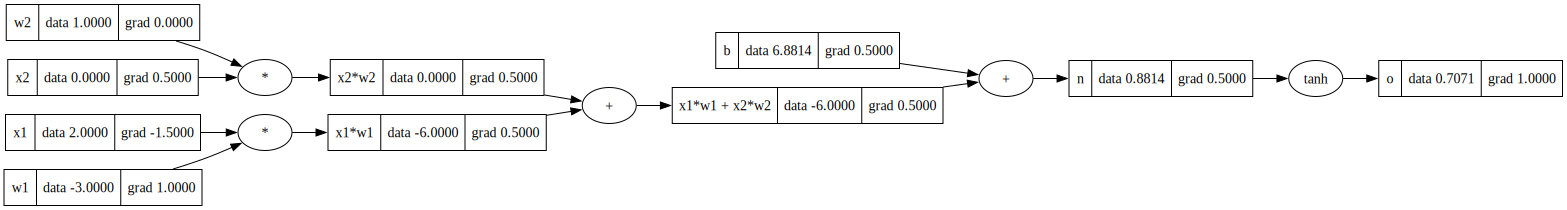

In [6]:
draw_dot(o)

In [7]:
# inputs x1 x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

# weights w1 w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

# bias of neuron
b = Value(6.8813735870195432, label='b')

# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label='x1*w1'
x2w2 = x2*w2; x2w2.label='x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label='n'

# BREAKING UP TANH
# o = n.tanh()
# ---------
e = (2 * n).exp()
o = (e - 1) / (e + 1)
# ---------

o.label='o'
o.backward()

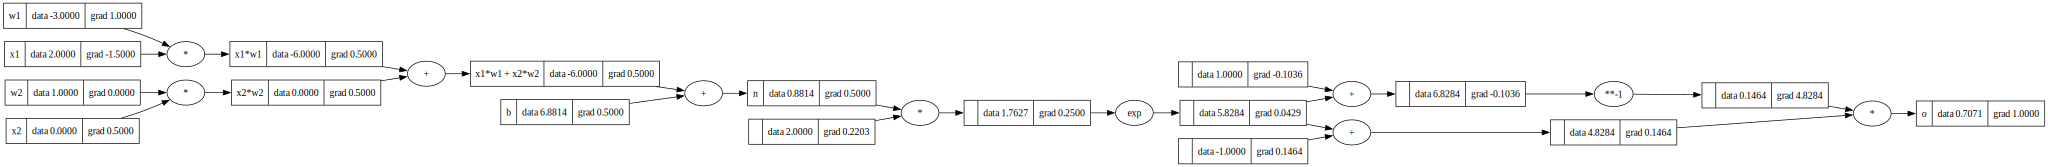

In [8]:
draw_dot(o)

In [9]:
# Let's do the same thing in pytorch

import torch

# Define directly in the constructor to keep them as leaf tensors
x1 = torch.tensor([2.0], dtype=torch.double, requires_grad=True)
w1 = torch.tensor([-3.0], dtype=torch.double, requires_grad=True)
x2 = torch.tensor([0.0], dtype=torch.double, requires_grad=True)
w2 = torch.tensor([1.0], dtype=torch.double, requires_grad=True)
b  = torch.tensor([6.8813735870195432], dtype=torch.double, requires_grad=True)

# Forward pass
n = x1*w1 + x2*w2 + b
o = torch.tanh(n)
print(o.data.item())

# Backward pass
o.backward()

# Print Results
print("----------")
assert x1.grad is not None
assert w1.grad is not None
assert x2.grad is not None
assert w2.grad is not None
print('x1 grad:', x1.grad.item())
print('w1 grad:', w1.grad.item())
print('x2 grad:', x2.grad.item())
print('w2 grad:', w2.grad.item())

0.7071067811865476
----------
x1 grad: -1.4999999999999996
w1 grad: 0.9999999999999998
x2 grad: 0.4999999999999999
w2 grad: 0.0


In [10]:
o

tensor([0.7071], dtype=torch.float64, grad_fn=<TanhBackward0>)